In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

## Reading the data

In [3]:
iris = load_iris(as_frame=True)
df = iris.frame
# set dtype
df["target"] = df["target"].astype("category")
df["variety"] = df["target"].map(dict(zip(range(3), iris.target_names)))
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,variety
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [4]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
df["variety"].value_counts()

setosa        50
versicolor    50
virginica     50
Name: variety, dtype: int64

# Data Analysis

## Distributions

Text(0.5, 1.0, 'Iris Dataset Boxplot')

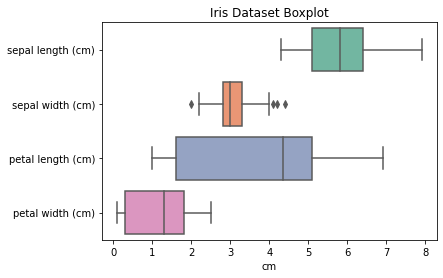

In [6]:
# Boxplot of the data
g = sns.boxplot(data=df, orient="h", palette="Set2")
g.set(xlabel="cm", ylabel="")
g.set_title("Iris Dataset Boxplot")

Text(0.5, 0.98, 'Iris Dataset Pairplot')

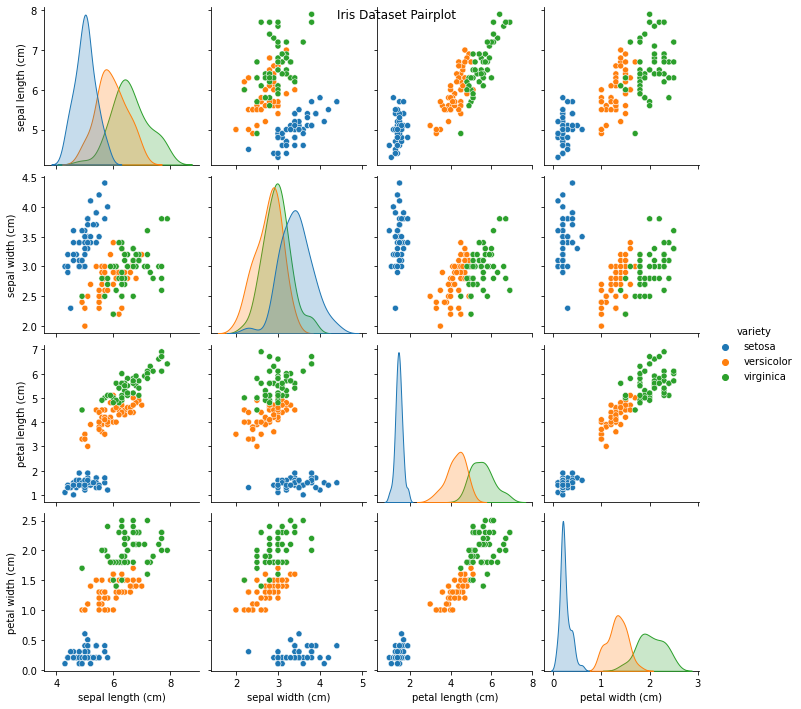

In [7]:
# Use seaborn to plot the data
g = sns.pairplot(df, hue="variety")
g.fig.suptitle("Iris Dataset Pairplot")

## Correlation matrix

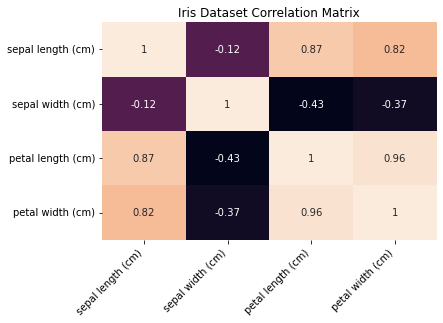

In [8]:
# correlation matrix with seaborn
g = sns.heatmap(df.corr(), annot=True, cbar=False)
_ = g.set_title("Iris Dataset Correlation Matrix")
_ = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment="right")

## PCA

Text(0.5, 0.92, 'PCA of the Iris dataset\nn_components=3')

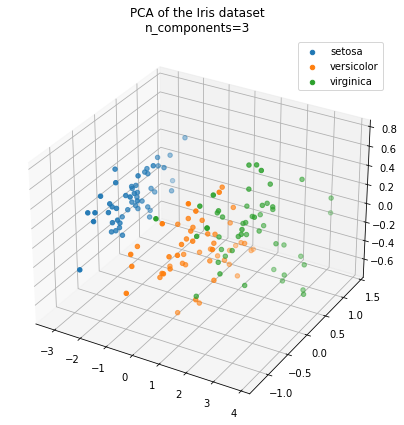

In [9]:
# Visualise species distribution in 3D
pca = PCA(n_components=3)
X, y = iris.data, iris.target
X = pca.fit_transform(X)
X, Y, Z = X[:, 0], X[:, 1], X[:, 2]
# plot 3D
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")

for s in range(3):
    ax.scatter(X[y == s], Y[y == s], Z[y == s], label=iris.target_names[s])
ax.legend()
# set title
ax.set_title("PCA of the Iris dataset\nn_components=3")
    

# Modelling

## Preprocessing

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In this stage we apply the following transformations to the data:
- **Scaling**: We scale the data to have zero mean and unit variance. This is done to avoid that features with large values dominate the objective function.
- **One-hot encoding**: We transform the categorical features into binary features. This is done to avoid that the model interprets the categorical features as ordinal.
- **Train-test split**: We split the data into a training set and a test set. The training set is used to train the model, while the test set is used to evaluate the model's performance on unseen data.

In [11]:
sc = StandardScaler()
oe = OneHotEncoder(sparse=False)

In [12]:
X, y = sc.fit_transform(iris.data), oe.fit_transform(iris.target.values.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Design

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.vis_utils import plot_model

In [42]:
model = Sequential(
    [
        Dense(units=8, activation="gelu"),
        Dropout(0.2),
        Dense(units=8, activation="gelu"),
        Dropout(0.2),
        Dense(units=4, activation="gelu"),
        Dense(units=3, activation="softmax")
    ]
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.build(input_shape=(None, 4))

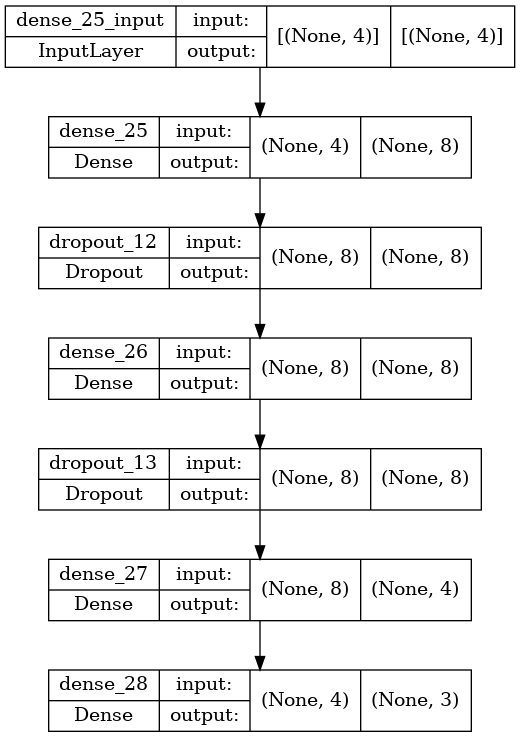

In [43]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Train

In [44]:
from keras.callbacks import Callback
from IPython.display import clear_output

In [45]:
# Module to plot the learning curve
# Retrieved from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure(figsize=(15, 10))
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        
        clear_output(wait=True)
        
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        # Draw horzontal line to indicate top accuracy
        ax2.axhline(y=max(self.val_acc), color='r', linestyle='--')
        
        
        plt.suptitle(f"Epoch {self.i} | Accuracy: {self.acc[-1]:.4f} | Validation Accuracy: {self.val_acc[-1]:.4f}")
        plt.show()
plot = PlotLearning()

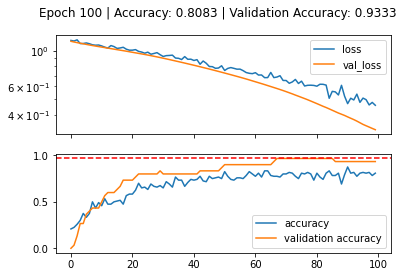

3/3 [==============================] - 0s 117ms/step - loss: 0.4579 - accuracy: 0.8083 - val_loss: 0.3227 - val_accuracy: 0.9333


In [46]:
history = model.fit(X_train, y_train, batch_size=40, epochs=100, validation_data=(X_test, y_test), callbacks=[plot])

## Evaluation

In [47]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

### Confusion matrix

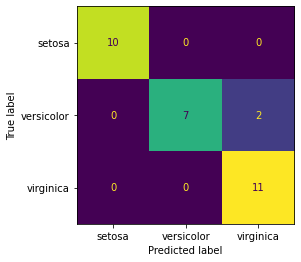

In [48]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
ConfusionMatrixDisplay(cm, display_labels=iris.target_names).plot(colorbar=False)